In [1]:
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np

from kernel import KernelComputer, KernelRegressor
from dataloader import Synthesizer

In [2]:
%matplotlib inline
np.random.seed(0)

## Toy problem

Let's imagine a toy problem, where we have to order $m$ linear forms over $X = \mathbb{R}$

In [3]:
n_train = 100
n_test = 200
exp_par, offset = 3, .5
proportion = .7
corruption = exp_par, offset

datagen = Synthesizer('IR-' + str(n_train))
x_train, y_train = datagen.get_trainset()
y_train += 3
bad_ind = np.random.rand(n_train) < proportion
good_ind = ~bad_ind

x_test, y_test = datagen.get_testset(n_test)
y_test += 3

S_train = datagen.synthetic_corruption(y_train, corruption)
c_train, r_train = S_train

In [4]:
exp_par, offset = corruption
r_train = abs(offset) - np.log(np.random.rand(n_train)) / exp_par
mu = (2 * np.random.rand(n_train) - 1) * r_train
# c_train = y_train + np.abs(mu)[:, np.newaxis] * np.sign(y_train)
c_train = y_train + mu[:, np.newaxis]

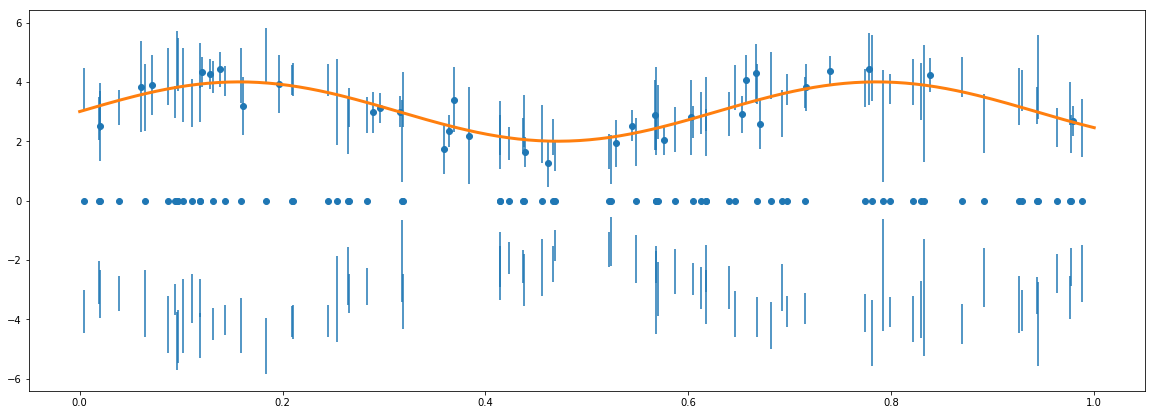

In [17]:
fig, ax = plt.subplots(figsize=(20, 7))
a = ax.errorbar(x_train[:, 0], c_train[:, 0], yerr=r_train, fmt=' ', color="C0")
ax.errorbar(x_train[bad_ind, :], -c_train[bad_ind, 0], yerr=r_train[bad_ind], fmt=' ', color="C0")
b = ax.scatter(x_train[bad_ind, 0], np.zeros(bad_ind.sum()), color="C0")
ax.scatter(x_train[good_ind].squeeze(), c_train[good_ind].squeeze(), color="C0")
b, = ax.plot(x_test[:, 0], y_test[:, 0], linestyle="-", linewidth=3, color="C1")

In [6]:
def l2_loss(A, B):
    dist = A @ B.T
    dist *= -2
    dist += np.sum(A ** 2, axis=1)[:, np.newaxis]
    dist += np.sum(B ** 2, axis=1)
    return dist


def point_l2_loss(a, b):
    dist = a - b
    dist **= 2
    dist = np.sum(dist, axis=1)
    return dist

In [7]:
y_grid = np.linspace(-6, 6, num=1000)[:, np.newaxis]
AC_loss = l2_loss(c_train, y_grid)
AC_loss[bad_ind] = np.sum(y_grid ** 2, axis=1)

IL_loss_pos = l2_loss(c_train, y_grid)
IL_loss_pos -= r_train[:, np.newaxis]
IL_loss_neg = l2_loss(-c_train, y_grid)
IL_loss_neg -= r_train[:, np.newaxis]
IL_loss_neg[good_ind] = np.inf
IL_loss = np.stack((IL_loss_pos, IL_loss_neg)).min(axis=0)
IL_loss[IL_loss < 0] = 0
IL_loss **= 2

In [8]:
kernel = KernelComputer('Laplacian', sigma=1)

In [9]:
kernel_reg = KernelRegressor(kernel)
kernel_reg.set_support(x_train)

sigmas = [1e0, 5e-1, 1e-1, 5e-2, 1e-2]
lambdas = [1e3, 1e0, 1e-3]

best_err_ac, best_err_il = np.inf, np.inf
best_s_ac, best_s_il = None, None
best_l_ac, best_l_il = None, None

for sigma in sigmas:
    kernel_reg.update_sigma(sigma)
    for lambd in lambdas:
        kernel_reg.update_lambda(lambd)
        alpha = kernel_reg(x_test)
        
        loss_grid = alpha @ AC_loss
        y_ac = y_grid[np.argmin(loss_grid, axis=1)]

        loss_grid = alpha @ IL_loss
        y_il = y_grid[np.argmin(loss_grid, axis=1)]
        
        err_ac = np.diag(l2_loss(y_ac, y_test)).mean()
        err_il = np.diag(l2_loss(y_il, y_test)).mean()
        
        if err_ac < best_err_ac:
            best_err_ac = err_ac
            best_s_ac = sigma
            best_l_ac = lambd
            best_y_ac = y_ac
            
        if err_il < best_err_il:
            best_err_il = err_il
            best_s_il = sigma
            best_l_il = lambd
            best_y_il = y_il

In [10]:
best_err_il, best_err_ac, best_s_il, best_s_ac, best_l_il, best_l_ac

(0.03790599980330573, 5.249488178501921, 0.01, 0.1, 1.0, 1000.0)

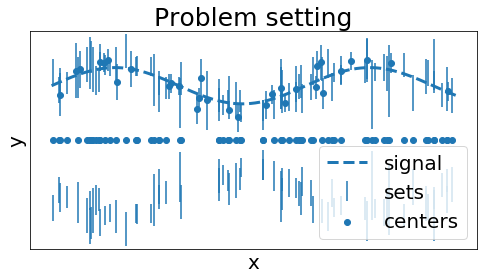

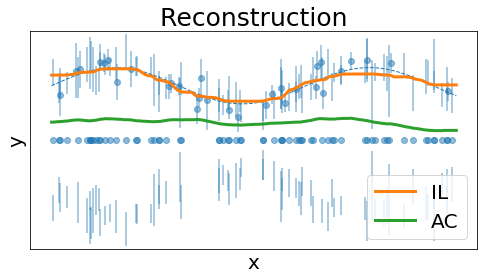

In [12]:
fig1, ax1 = plt.subplots(figsize=(8, 4))
a, = ax1.plot(x_test[:, 0], y_test[:, 0], linestyle="--", linewidth=3, color="C0")
b = ax1.errorbar(x_train[:, 0], c_train[:, 0], yerr=r_train, fmt=' ', color="C0")
ax1.errorbar(x_train[bad_ind, :], -c_train[bad_ind, 0], yerr=r_train[bad_ind], fmt=' ', color="C0")
c = ax1.scatter(x_train[bad_ind, 0], np.zeros(bad_ind.sum()), color="C0")
ax1.scatter(x_train[good_ind, 0], c_train[good_ind, 0], color="C0")
ax1.legend([a, b, c], ["signal", "sets", "centers"], prop={"size": 20})
ax1.set_title("Problem setting", size=25)

fig2, ax2 = plt.subplots(figsize=(8, 4))
ax2.plot(x_test[:, 0], y_test[:, 0], linestyle="--", linewidth=1, color="C0")
alpha = .5
ax2.errorbar(x_train[:, 0], c_train[:, 0], yerr=r_train, fmt=' ', color="C0", alpha=alpha)
ax2.errorbar(x_train[bad_ind, :], -c_train[bad_ind, 0], yerr=r_train[bad_ind], fmt=' ', color="C0", alpha=alpha)
ax2.scatter(x_train[bad_ind, 0], np.zeros(bad_ind.sum()), color="C0", alpha=alpha)
ax2.scatter(x_train[good_ind, 0], c_train[good_ind, 0], color="C0", alpha=alpha)
a, = ax2.plot(x_test.squeeze(), best_y_il.squeeze(), linestyle="-", linewidth=3, color="C1")
b, = ax2.plot(x_test[:, 0], best_y_ac[:, 0], linestyle="-", linewidth=3, color="C2")
ax2.legend([a, b], ['IL', 'AC'], prop={'size':20})
ax2.set_title("Reconstruction", size=25)

for ax in [ax1, ax2]:
    ax.set_xlabel("x", size=20)
    ax.set_ylabel("y", size=20)
    ax.set_ylim(-6, 6)
    ax.tick_params(
        axis='both',
        which='both',
        bottom=False,
        left=False,
        labelbottom=False,
        labelleft=False)

fig1.savefig('savings/ir_setting.pdf')
fig2.savefig('savings/ir_reconstruction.pdf')